# Step-by-step demonstration

## Lib Imports and configurations

In [6]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")
import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading event log

In [7]:
# Mapping all event_logs paths
logs_path = glob.glob("Input\Real\BPI Challenge 2020/*.xes.gz")

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  5


,0
0,Input\Real\BPI Challenge 2020\DomesticDeclarations.xes.gz
1,Input\Real\BPI Challenge 2020\InternationalDeclarations.xes.gz
2,Input\Real\BPI Challenge 2020\PermitLog.xes.gz
3,Input\Real\BPI Challenge 2020\PrepaidTravelCost.xes.gz
4,Input\Real\BPI Challenge 2020\RequestForPayment.xes.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [13]:
# Loading first event log
log_path = logs_path[0]
print(log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_xes(log_path)

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('case:id')))
print("Total activities: ", len(event_log.groupby('concept:name')))
event_log.head(15)

DomesticDeclarations


parsing log, completed traces :: 100%|██████████| 10500/10500 [00:01<00:00, 8888.23it/s]


Total events:  56437
Total cases:  10500
Total activities:  17


,original_index,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
1,1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
2,2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
3,3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 17:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
4,4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.4642
5,5,st_step 86799_0,STAFF MEMBER,Declaration APPROVED by PRE_APPROVER,2017-02-22 10:29:21+00:00,PRE_APPROVER,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.4642
6,6,st_step 86797_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-02-23 08:14:45+00:00,SUPERVISOR,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.4642
7,7,dd_declaration 86795_19,SYSTEM,Request Payment,2017-03-06 14:07:25+00:00,UNDEFINED,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.4642
8,8,dd_declaration 86795_20,SYSTEM,Payment Handled,2017-03-13 17:30:59+00:00,UNDEFINED,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.4642
9,9,st_step 86804_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 11:13:33+00:00,EMPLOYEE,declaration 86800,declaration 86800,budget 86566,declaration number 86801,320.6461


## Step 1 - Instantiating class and setting event log

In [14]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='case:id', activity_key='concept:name', timestamp_key='time:timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(20)

66937


,case_id,activity_from,timestamp_from,event_order_from,activity_to,timestamp_to,event_order_to,case_order,transition_id
0,declaration 86791,START,2017-01-09 09:49:50+00:00,0,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+00:00,0.0000,0,0
1,declaration 86791,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+00:00,0,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+00:00,1.0000,1,1
2,declaration 86791,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+00:00,1,Request Payment,2017-01-10 09:34:44+00:00,2.0000,2,2
3,declaration 86791,Request Payment,2017-01-10 09:34:44+00:00,2,Payment Handled,2017-01-12 17:31:22+00:00,3.0000,3,3
4,declaration 86791,Payment Handled,2017-01-12 17:31:22+00:00,3,END,2017-01-12 17:31:22+00:00,3.0000,4,4
5,declaration 86795,START,2017-01-09 10:26:14+00:00,4,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+00:00,4.0000,0,5
6,declaration 86795,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+00:00,4,Declaration APPROVED by PRE_APPROVER,2017-02-22 10:29:21+00:00,5.0000,1,6
7,declaration 86795,Declaration APPROVED by PRE_APPROVER,2017-02-22 10:29:21+00:00,5,Declaration FINAL_APPROVED by SUPERVISOR,2017-02-23 08:14:45+00:00,6.0000,2,7
8,declaration 86795,Declaration FINAL_APPROVED by SUPERVISOR,2017-02-23 08:14:45+00:00,6,Request Payment,2017-03-06 14:07:25+00:00,7.0000,3,8
9,declaration 86795,Request Payment,2017-03-06 14:07:25+00:00,7,Payment Handled,2017-03-13 17:30:59+00:00,8.0000,4,9


## Step 2 - Setting Window Strategy

In [24]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 4000, window_ref_mode = 'Sliding', overlap = True, sliding_step = 200, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items()))

{0: {'start': 0, 'end': 4000, 'window_index': 0},
 1: {'start': 200, 'end': 4200, 'window_index': 1},
 2: {'start': 400, 'end': 4400, 'window_index': 2},
 3: {'start': 600, 'end': 4600, 'window_index': 3},
 4: {'start': 800, 'end': 4800, 'window_index': 4},
 5: {'start': 1000, 'end': 5000, 'window_index': 5},
 6: {'start': 1200, 'end': 5200, 'window_index': 6},
 7: {'start': 1400, 'end': 5400, 'window_index': 7},
 8: {'start': 1600, 'end': 5600, 'window_index': 8},
 9: {'start': 1800, 'end': 5800, 'window_index': 9},
 10: {'start': 2000, 'end': 6000, 'window_index': 10},
 11: {'start': 2200, 'end': 6200, 'window_index': 11},
 12: {'start': 2400, 'end': 6400, 'window_index': 12},
 13: {'start': 2600, 'end': 6600, 'window_index': 13},
 14: {'start': 2800, 'end': 6800, 'window_index': 14},
 15: {'start': 3000, 'end': 7000, 'window_index': 15},
 16: {'start': 3200, 'end': 7200, 'window_index': 16},
 17: {'start': 3400, 'end': 7400, 'window_index': 17},
 18: {'start': 3600, 'end': 7600, 'wi

## Step 3 - Setting Process Representation (using Transition Matrix)

In [25]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.005
                                    , control_flow_features={'frequency', 'probability'}
                                    , time_features={} 
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation()#.head(15)

frequency  \
activity_from                            activity_to                                           
Declaration APPROVED by ADMINISTRATION   Declaration APPROVED by BUDGET OWNER           2820   
                                         Declaration FINAL_APPROVED by SUPERVISOR       5133   
Declaration APPROVED by BUDGET OWNER     Declaration FINAL_APPROVED by SUPERVISOR       2788   
Declaration APPROVED by PRE_APPROVER     Declaration FINAL_APPROVED by SUPERVISOR        674   
Declaration FINAL_APPROVED by SUPERVISOR Request Payment                               10038   
Declaration REJECTED by ADMINISTRATION   Declaration REJECTED by EMPLOYEE                928   
Declaration REJECTED by EMPLOYEE         Declaration SUBMITTED by EMPLOYEE              1081   
Declaration SUBMITTED by EMPLOYEE        Declaration APPROVED by ADMINISTRATION         8202   
                                         Declaration APPROVED by PRE_APPROVER            685   
                                         Declaration FINAL_APPROVED by SUPERVISOR       1536   
                                         Declaration REJECTED by ADMINISTRATION          952   
Payment Handled                          END                                           10043   
Request Payment                          Payment Handled                               10037   
START                                    Declaration SUBMITTED by EMPLOYEE             10365   

                                                                                   percentual  \
activity_from                            activity_to                                            
Declaration APPROVED by ADMINISTRATION   Declaration APPROVED by BUDGET OWNER          0.0421   
                                         Declaration FINAL_APPROVED by SUPERVISOR      0.0767   
Declaration APPROVED by BUDGET OWNER     Declaration FINAL_APPROVED by SUPERVISOR      0.0417   
Declaration APPROVED by PRE_APPROVER     Declaration FINAL_APPROVED by SUPERVISOR      0.0101   
Declaration FINAL_APPROVED by SUPERVISOR Request Payment                               0.1500   
Declaration REJECTED by ADMINISTRATION   Declaration REJECTED by EMPLOYEE              0.0139   
Declaration REJECTED by EMPLOYEE         Declaration SUBMITTED by EMPLOYEE             0.0161   
Declaration SUBMITTED by EMPLOYEE        Declaration APPROVED by ADMINISTRATION        0.1225   
                                         Declaration APPROVED by PRE_APPROVER          0.0102   
                                         Declaration FINAL_APPROVED by SUPERVISOR      0.0229   
                                         Declaration REJECTED by ADMINISTRATION        0.0142   
Payment Handled                          END                                           0.1500   
Request Payment                          Payment Handled                               0.1499   
START                                    Declaration SUBMITTED by EMPLOYEE             0.1548   

                                                                                   probability  
activity_from                            activity_to                                            
Declaration APPROVED by ADMINISTRATION   Declaration APPROVED by BUDGET OWNER           0.3546  
                                         Declaration FINAL_APPROVED by SUPERVISOR       0.6454  
Declaration APPROVED by BUDGET OWNER     Declaration FINAL_APPROVED by SUPERVISOR       1.0000  
Declaration APPROVED by PRE_APPROVER     Declaration FINAL_APPROVED by SUPERVISOR       1.0000  
Declaration FINAL_APPROVED by SUPERVISOR Request Payment                                1.0000  
Declaration REJECTED by ADMINISTRATION   Declaration REJECTED by EMPLOYEE               1.0000  
Declaration REJECTED by EMPLOYEE         Declaration SUBMITTED by EMPLOYEE              1.0000  
Declaration SUBMITTED by EMPLOYEE        Declaration APPROVED by ADMINISTRATION         0.7211  
                       

## Step 4 - Setting Change Representation

In [26]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(15)

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200,4200,1,0,59.0000,1.0336,0.0075,24.2880,1.0000,0.0000
2,400,4400,2,1,56.0000,1.0156,0.0072,23.0484,1.0000,0.0000
3,600,4600,3,2,22.0000,0.0180,0.0028,0.0555,1.0000,0.0000
4,800,4800,4,3,15.0000,0.0091,0.0019,0.0255,1.0000,0.0000
5,1000,5000,5,4,42.0000,0.0330,0.0054,0.3499,1.0000,0.0000
6,1200,5200,6,5,42.0000,0.0276,0.0054,0.2886,1.0000,0.0000
7,1400,5400,7,6,25.0000,0.0223,0.0032,0.0960,1.0000,0.0000
8,1600,5600,8,7,38.0000,0.0731,0.0049,0.6845,1.0000,0.0000
9,1800,5800,9,8,12.0000,0.0058,0.0015,0.0075,1.0000,0.0000


## Step 5 - Setting Detection Task

In [27]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[43, 64, 109, 154, 315]"
1,time_series_strategy,cpd_prob_freq_delta,"[44, 67, 230, 260, 315]"
2,time_series_strategy,cramersv_frequency,"[35, 56, 77, 98, 119, 140, 161, 182, 203, 224, 245, 266, 290, 315]"
3,threshold_strategy,cramersv_frequency,[315]
4,threshold_strategy,gtest_frequency,[315]


In [28]:
### Grounding truth
log_size = event_log['case:id'].nunique()
ground_truth_traces_indexes = list(range(int(log_size/10), log_size, int(log_size/10)))

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

ground_truth:  [315]


In [29]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan
    
detection_task_results

Error: division by zero
Error: division by zero
Error: division by zero
Error: zero-size array to reduction operation minimum which has no identity
Error: zero-size array to reduction operation minimum which has no identity


,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[43, 64, 109, 154, 315]",[315],NaN,NaN
1,time_series_strategy,cpd_prob_freq_delta,"[44, 67, 230, 260, 315]",[315],NaN,NaN
2,time_series_strategy,cramersv_frequency,"[35, 56, 77, 98, 119, 140, 161, 182, 203, 224, 245, 266, 290, 315]",[315],NaN,NaN
3,threshold_strategy,cramersv_frequency,[315],[315],NaN,NaN
4,threshold_strategy,gtest_frequency,[315],[315],NaN,NaN


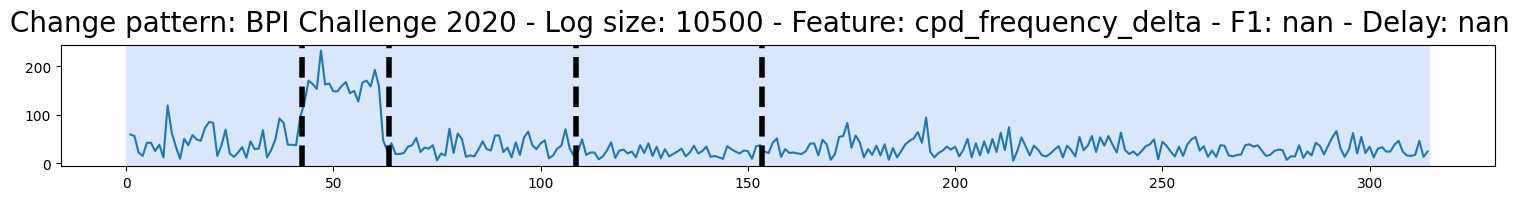

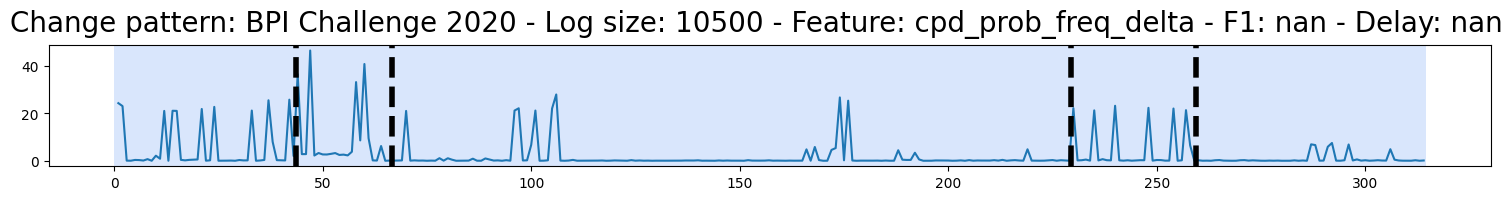

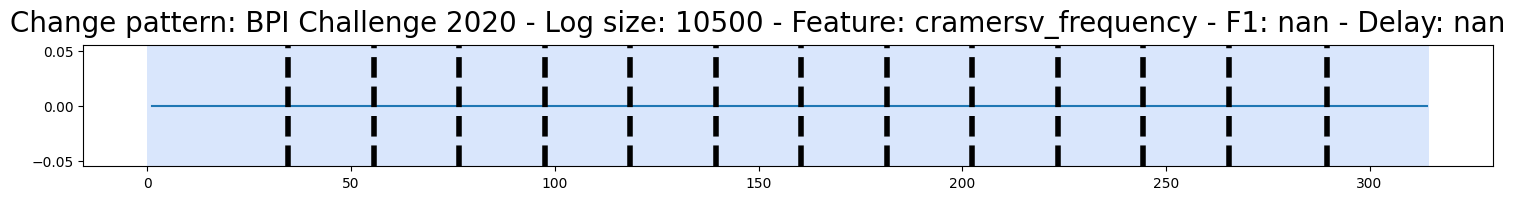

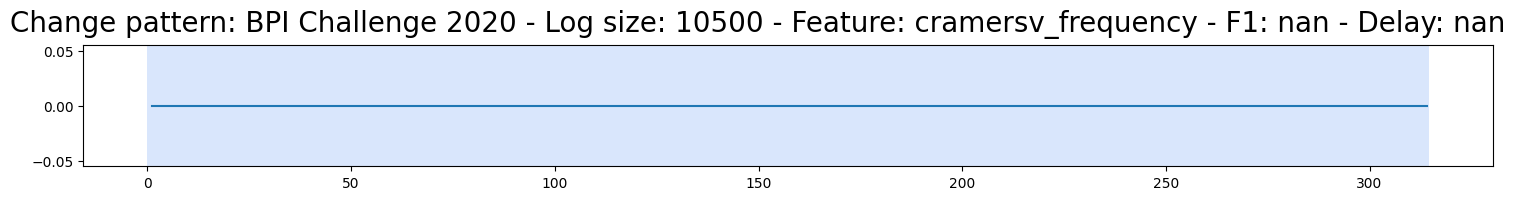

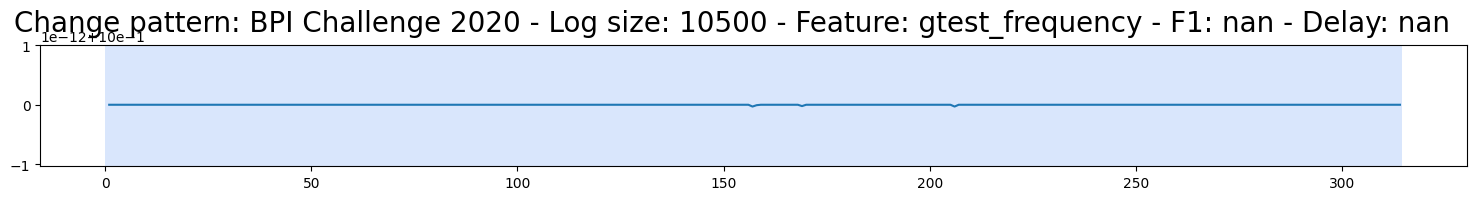

In [30]:
### Display Detection Task Results 

for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change pattern: " + log_path.split("\\")[-2] 
                 + " - Log size: " + str(log_size)
                 + " - Feature: " + result.detection_feature
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=20)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

In [ ]:
# Setting Localization Task
TMPD_instance.set_localization_task(reference_window_index=0, detection_window_index=75, pvalue_threshold=0.05, effect_prop_threshold=0.2, effect_count_threshold=0.02, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=True)

In [ ]:
### Ground Truth
change_pattern_ground_truth = log_path.split("\\")[-2]

change_activities_ground_truth = {
    'cb': {
        'change_pattern_name': 'Skip',
        'characterization_activities': ['Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote']
    },
    'cd': {
        'change_pattern_name': 'Control-Dependency',
        'characterization_activities': ['Check_credit_history', 'Assess_loan_risk'],
        'localization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history']
    },
    'cf': {
        'change_pattern_name': 'Conditional-To-Sequence',
        'characterization_activities': ['Send_home_insurance_quote', 'Send_acceptance_pack'],
        'localization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement']
    },
    'cm': {
        'change_pattern_name': 'Conditional-Move',
        'characterization_activities': ['Prepare_acceptance_pack'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'cp': {
        'change_pattern_name': 'Copy',
        'characterization_activities': ['Assess_loan_risk', 'Check_credit_history'],
        'localization_activities': ['Assess_loan_risk', 'Check_credit_history', 'Verify_repayment_agreement', 'Approve_application', 'Cancel_application']
    },
    'fr': {
        'change_pattern_name': 'Frequency',
        'characterization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement'],
        'localization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement']
    },
    'lp': {
        'change_pattern_name': 'Loop',
        'characterization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history'],
        'localization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history', 'Reject_application', 'Prepare_acceptance_pack']
    },
    'pl': {
        'change_pattern_name': 'Parallel-To-Sequence',
        'characterization_activities': ['Appraise_property', 'Check_credit_history', 'Assess_loan_risk'],
        'localization_activities': ['Assess_loan_risk', 'Check__application__form_completeness', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history']
    },
    'pm': {
        'change_pattern_name': 'Parallel-Move',
        'characterization_activities': ['Prepare_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    're': {
        'change_pattern_name': 'Serial-Switch',
        'characterization_activities': ['Assess_eligibility'],
        'localization_activities': ['Assess_eligibility', 'Reject_application', 'Prepare_acceptance_pack', 'Assess_loan_risk']
    },
    'rp': {
        'change_pattern_name': 'Replace',
        'characterization_activities': ['Verify_repayment_agreement', 'Replaced_Activity'],
        'localization_activities': ['Cancel_application', 'Send_acceptance_pack', 'Replaced_Activity', 'Approve_application', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'sw': {
        'change_pattern_name': 'Swap',
        'characterization_activities': ['Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Verify_repayment_agreement'],
        'localization_activities': ['Send_acceptance_pack', 'Cancel_application', 'Check_if_home_insurance_quote_is_requested', 'Approve_application', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    }
    # , 'IOR': []
    # , 'IRO': []
    # , 'OIR': []
    # , 'ORI': []
    # , 'RIO': []
    # , 'ROI': []
}

localization_ground_truth = change_activities_ground_truth[change_pattern_ground_truth]['localization_activities']
localization_ground_truth

In [ ]:
### Validation metrics

# Getting the distinct activities in the Localization Result
localization_distinct_activities = set()
for key, value in islice(TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1].items(), 6):
    if isinstance(value, list): # Check if the value is a list
        # Skip the list if it contains only "None"
        if len(value) == 1 and value[0] == "None":
            continue
        for item in value:
            if isinstance(item, tuple): # If the items are tuples, extend the set with the tuple items
                localization_distinct_activities.update(item)
            else: # If the items are not tuples (i.e., strings), add them directly to the set
                localization_distinct_activities.add(item)
localization_result = list(localization_distinct_activities)
print(localization_result)

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(localization_ground_truth, localization_result)

localization_task_validation_results = ({
    'localization_activities_precision': precision,
    'localization_activities_recall': recall,
    'localization_activities_f1_score': f1_score
})

localization_task_validation_results

In [ ]:
# # Skip Pattern temporary test
# TMPD_instance.detection_bpmn_text = "Sequence( 'Loan__application_received', Loop( 'Check__application__form_completeness', Sequence( 'Return_application_back_to_applicant', 'Receive_updated_application' ) ), Parallel( 'Appraise_property', Sequence( 'Check_credit_history', 'Assess_loan_risk' ) ), 'Assess_eligibility', Conditional( Sequence( Conditional( Sequence( 'Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested') , 'tau'), Conditional( 'Send_acceptance_pack', 'Send_home_insurance_quote' ), 'Verify_repayment_agreement', Conditional( Sequence( 'Cancel_application', 'Loan__application_canceled' ), Sequence( 'Approve_application', 'Loan__application_approved' ) ) ), Sequence( 'Reject_application', 'Loan_application_rejected' ) ) )"
# TMPD_instance.detection_bpmn_text

## Step 6b - Setting Characterization Task

In [ ]:
# Setting Characterization Task
# TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4o", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v0.yaml') # "gpt-4o", "gpt-3.5-turbo-0125", "gpt-4"
TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-2.0-flash", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v0.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
TMPD_instance.get_characterization_task()

In [ ]:
### Ground Truth
characterization_ground_truth = {'concept_drift' : ['Yes'], 'change_pattern' : [change_activities_ground_truth[change_pattern_ground_truth]['change_pattern_name']], 'activities' : change_activities_ground_truth[change_pattern_ground_truth]['characterization_activities']}
characterization_ground_truth


In [ ]:
### Validation metrics

characterization_result = TMPD_instance.get_characterization_task()[0]

# Initialize a results dictionary
characterization_task_validation_results = {
    'characterization_concept_drift_match': None,
    'characterization_change_pattern_match_f1_score': None,
    'characterization_change_pattern_match_precision': None,
    'characterization_change_pattern_match_recall': None,
    'characterization_activities_precision': None,
    'characterization_activities_recall': None,
    'characterization_activities_f1_score': None
}

# Check matches
try:
    characterization_task_validation_results['characterization_concept_drift_match'] = TMPD_utils.list_match_metrics(characterization_ground_truth['concept_drift'], characterization_result['concept_drift'])[2]
except:
    characterization_task_validation_results['characterization_concept_drift_match'] = -1

try:
    precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['change_pattern'], characterization_result['change_pattern'])
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': f1_score,
        'characterization_change_pattern_match_precision': precision,
        'characterization_change_pattern_match_recall': recall
    })

except:
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': -1,
        'characterization_change_pattern_match_precision': -1,
        'characterization_change_pattern_match_recall': -1
    })

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['activities'], characterization_result['activities'])

characterization_task_validation_results.update({
    'characterization_activities_precision': precision,
    'characterization_activities_recall': recall,
    'characterization_activities_f1_score': f1_score
})

characterization_task_validation_results


In [ ]:
understanding_tasks_results = pd.DataFrame([{**characterization_task_validation_results}])
understanding_tasks_results['localization_activities'] = ', '.join(localization_result) 
understanding_tasks_results['characterization_change_pattern'] = ', '.join(TMPD_instance.get_characterization_task()[0]['change_pattern']) 
understanding_tasks_results['characterization_activities'] = ', '.join(TMPD_instance.get_characterization_task()[0]['activities']) 
understanding_tasks_results['localization_changes'] = [TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1]]
understanding_tasks_results['reference_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[2]
understanding_tasks_results['detection_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[3]
understanding_tasks_results['change_patterns_llm_response'] = TMPD_instance.get_characterization_task()[1]
understanding_tasks_results

## Step 6c - Setting Explanation Task

In [ ]:
# TODO